# Initialisation
We performed sanity checks using explainable AI (XAI) tools on the best MFCC and Log Mel Spectrogram models. As both feature extraction methods utilize Deep CNN architecture, we adopted the Grad-CAM visual explanations proposed by Selvaraju et al. (2019).

In [1]:
# Import libraries
import kagglehub as kagglehub # install kagglehub if needed
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import matplotlib.gridspec as gridspec
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [4]:
!pip install tf-explain
from tf_explain.core.grad_cam import GradCAM

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00


In [5]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, GlobalMaxPool2D, LSTM, Bidirectional, Dense, Flatten, Dropout, Concatenate, MultiHeadAttention
from tensorflow.keras.layers import Conv1D, AveragePooling1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPool1D

# Fetch the Metadata
This section loads all the 4 datasets (SAVEE, RAVEE, CREMA-D, TESS) to the working directory. The file paths are saved along with the emotion label ("angry", "happy", ...) and the original data sources. The text label is encoded to a numeric value using the following mapping.

```
{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}
```

 Finally, the metadata dataframe is splitted into training and validation data for future use.

In [6]:
# SAVEE Data
SAVEE = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")

SAVEE_PATH = SAVEE + '/ALL/'
dir_list = os.listdir(SAVEE_PATH)
dir_list[0:5]

# Get the data location for SAVEE
dir_list = os.listdir(SAVEE_PATH)

# parse the filename to get the emotions
emotion=[]
path = []

for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
    elif i[-8:-6]=='sa':
        emotion.append('sad')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
    else:
        emotion.append('error')
    path.append(SAVEE_PATH + i)

# create dataframe
SAVEE_df = pd.DataFrame(
    {
        "label": emotion,
        "path": path,
        "source": "SAVEE"
    }
)

In [7]:
# RAVDESS Data
RAV = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

emotions = []
gender = []
path = []
emotion_dict = {
    1: 'neutral',
    2: 'neutral',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}

for folder in os.listdir(RAV):

  folder_path = RAV + "/" + folder

  if "Actor" not in folder:
      continue

  for file in os.listdir(folder_path):
    path.append(folder_path + "/" + file)
    emo = int(file[6:8])
    emotions.append(emotion_dict[emo])

REV_df = pd.DataFrame(
    {
        "label": emotions,
        "path": path,
        "source" : "RAVEDESS"
    }
)

In [8]:
# CREMA-D Data
CREMAD = kagglehub.dataset_download("ejlok1/cremad")

emotions = []
path = []

emotion_dict = {
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fear",
    "HAP": "happy",
    "NEU": "neutral",
    "SAD": "sad"
}

for folder in os.listdir(CREMAD):

  folder_path = CREMAD + "/" + folder

  for file in os.listdir(folder_path):

    emo = file[9:12]
    file_path = folder_path + "/" + file

    # emotions
    emotions.append(emotion_dict[emo])
    path.append(file_path)

CREMA_df = pd.DataFrame(
    {
        "label": emotions,
        "path": path,
        "source": "CREMA"
    }
)

In [9]:
# TESS Data
TESS = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

TESS_path = TESS + '/TESS Toronto emotional speech set data/'
dir_list = os.listdir(TESS_path)

path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS_path + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral')
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise')
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad')
        else:
            emotion.append('Unknown')
        path.append(TESS_path + i + "/" + f)

TESS_df = pd.DataFrame(
    {
        "label": emotion,
        "path": path,
        "source": "TESS"
    }
)

In [10]:
# concate dataframe
metadata = pd.concat([SAVEE_df, REV_df, TESS_df, CREMA_df], axis = 0)


# shuffle the data
metadata = metadata.sample(frac = 1, replace = False, random_state = 42)

# split the metadata into train and test
le = LabelEncoder()
metadata["label_enc"] = le.fit_transform(metadata["label"])

meta_train, meta_val = train_test_split(metadata, test_size = 0.2, random_state = 42, stratify = metadata["label"])

In [11]:
# label mapping
emo_dict = {ind: label for ind, label in enumerate(le.classes_)}

# Log Mel Spectrogram
In this notebook, we re-train our best Log Mel Spectrogram model and utilise Grad-CAM method to detect regions in the input image that is important to the classification model. The Log Mel Spectrogram features is already extracted and saved during the model training phase, and we load them as numpy arrays from Google Drive, shuffle, and batch them. We also randomly selected one observation from each of the seven emotion classes to perform Grad-CAM and identify the model's ability in extracting meaningful information from the input data.

The plots below show that all samples are shorter than 4 seconds, and therefore are padded with 0 to form a 4-second audio. High-arousal emotions, such as Angry and Surprise, exhibit more intense signals than subtle ones (neutral, sad, fear). This is consistent with the confusion matrices results in model training notebooks, which shows that the former are easier to detect.

In [12]:
# load the data
train = np.load("/content/drive/MyDrive/SER_data/mel_train.npz")
val = np.load("/content/drive/MyDrive/SER_data/mel_val.npz")

X_train = train["X"]
y_train = train["y"]
y_train = tf.keras.utils.to_categorical(y_train) # one hot encoding

X_val = val["X"]
y_val = val["y"]
y_val = tf.keras.utils.to_categorical(y_val) # one hot encoding

# Create tf.data.Dataset
df_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)
df_val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)

In [13]:
##### sample one sample from each emotion category #####

sample_dict = {}
for i in range(7):
  temp = metadata[metadata["label_enc"] == i].sample(n = 1, random_state = 42)
  sample_dict[i] = temp.iloc[0,1] # append file path

sample_dict

{0: '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_keep_angry.wav',
 1: '/kaggle/input/cremad/AudioWAV/1005_TIE_DIS_XX.wav',
 2: '/kaggle/input/cremad/AudioWAV/1001_IWW_FEA_XX.wav',
 3: '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_lid_happy.wav',
 4: '/kaggle/input/cremad/AudioWAV/1066_TAI_NEU_XX.wav',
 5: '/kaggle/input/cremad/AudioWAV/1071_TAI_SAD_XX.wav',
 6: '/kaggle/input/ravdess-emotional-speech-audio/Actor_16/03-01-08-01-02-01-16.wav'}

In [14]:
# check label mappings
emo_dict

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [15]:
def load_audio_segment(path, sr=16000, duration=4.0):
    max_len = int(sr * duration)
    y, _ = librosa.load(path, sr=sr, duration=duration)
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    return y[:max_len]

# define a function to extract the log mel spectogram
def extract_mel(y, sr=16000, max_len = 126):

    S = librosa.feature.melspectrogram(y = y, sr = sr)
    spec = librosa.power_to_db(S, ref = np.max)
    if spec.shape[1] < max_len:
        pad_width = max_len - spec.shape[1]
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode="constant")
    else:
        spec = spec[:, :max_len]
    return spec

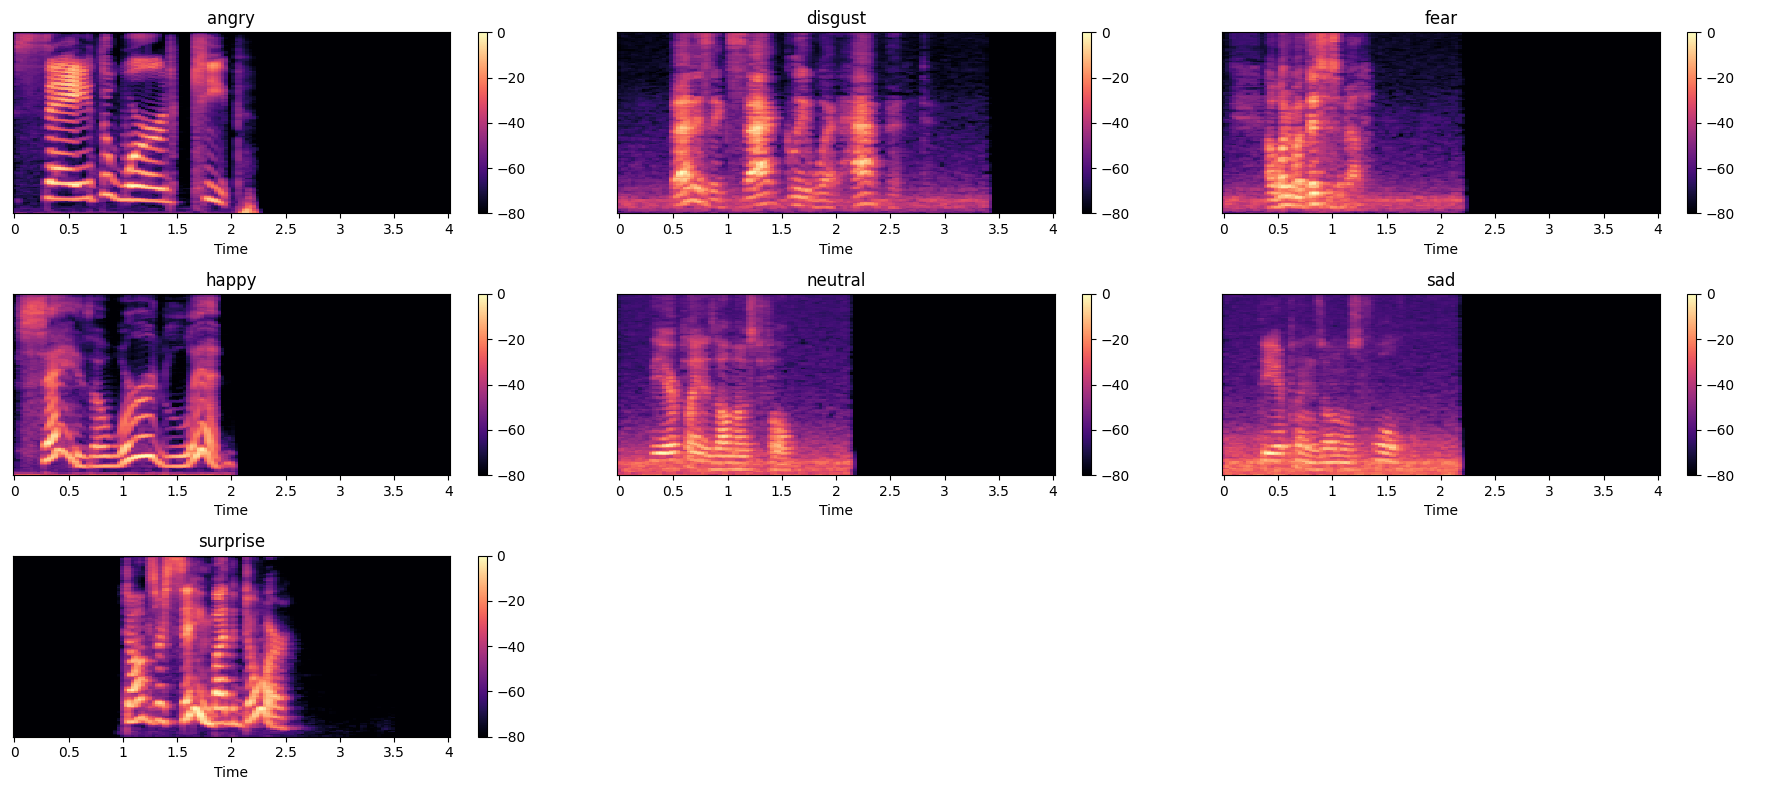

In [16]:
X_test = []
# plot Log Mel-Spectrogram
fig, ax = plt.subplots(3,3, figsize = (18,8))

for i in range(7):

  # load audio data
  X = load_audio_segment(sample_dict[i])

  # extract log mel spectrogram
  spec = extract_mel(X)

  ax = ax.flatten()
  img = librosa.display.specshow(spec, x_axis='time', sr=16000, ax = ax[i])
  ax[i].set(title = f"{emo_dict[i]}")
  fig.colorbar(img, ax = ax[i])
  plt.tight_layout()

  # add extracted features to the X_test list
  X_test.append(np.expand_dims(spec, axis = -1))

ax[7].set_axis_off()
ax[8].set_axis_off()

plt.show()

## Model Training

In [20]:
def build_deep_cnn(input_shape=(128, 126, 1), num_classes=7):
    input_shape = tf.keras.Input(shape=input_shape)

    for filters, dropout in zip([32, 64, 128, 256], [0.0, 0.0, 0.1, 0.2]):

        # different input for the first call
        if filters == 32:
          x = Conv2D(filters, (3, 3), padding='same')(input_shape)
        else:
          x = Conv2D(filters, (3, 3), padding='same')(x)

        x = BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(dropout)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(input_shape, x)

model1 = build_deep_cnn()
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 126, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14336)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,670,27

 Total params: 4,061,831 (15.49 MB)

 Trainable params: 4,060,871 (15.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [21]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_acc')]
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
]


hist1 = model1.fit(
    df_train,
    validation_data=df_val,
    epochs=70,
    callbacks=callbacks
)

Epoch 1/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2396 - loss: 2.8933 - top_3_acc: 0.5911
Epoch 1: val_accuracy improved from -inf to 0.19277, saving model to best_model.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.2403 - loss: 2.8870 - top_3_acc: 0.5921 - val_accuracy: 0.1928 - val_loss: 2.4756 - val_top_3_acc: 0.5080 - learning_rate: 1.0000e-04
Epoch 2/70
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3654 - loss: 2.0586 - top_3_acc: 0.7530
Epoch 2: val_accuracy improved from 0.19277 to 0.42129, saving model to best_model.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.3662 - loss: 2.0568 - top_3_acc: 0.7535 - val_accuracy: 0.4213 - val_loss: 2.1044 - val_top_3_acc: 0.7485 - learning_rate: 1.0000e-04
Epoch 3/70
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4530 - loss: 1.8504 - top_3_acc: 0.7986
Epoch 3: val_accuracy improved from 0.42129 to 0.53596, saving model to best_model.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - 

## GradCAM
Selvaraju et al. (2019) suggests that the last convolutional layer captures more spatial and semantic information than the first layers. For this reason, we selected the last convolutional layer (conv2d_7) for Grad-CAM. We started by running a prediction on the first sample (angry), as running the model once is required for the algorithm. We then apply Grad-CAM algorithm on each of the sampled data from each emotion label, and create a plot to compare the input image and the Grad-CAM output side-by-side.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_25']]
Received: inputs=Tensor(shape=(1, 128, 126, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


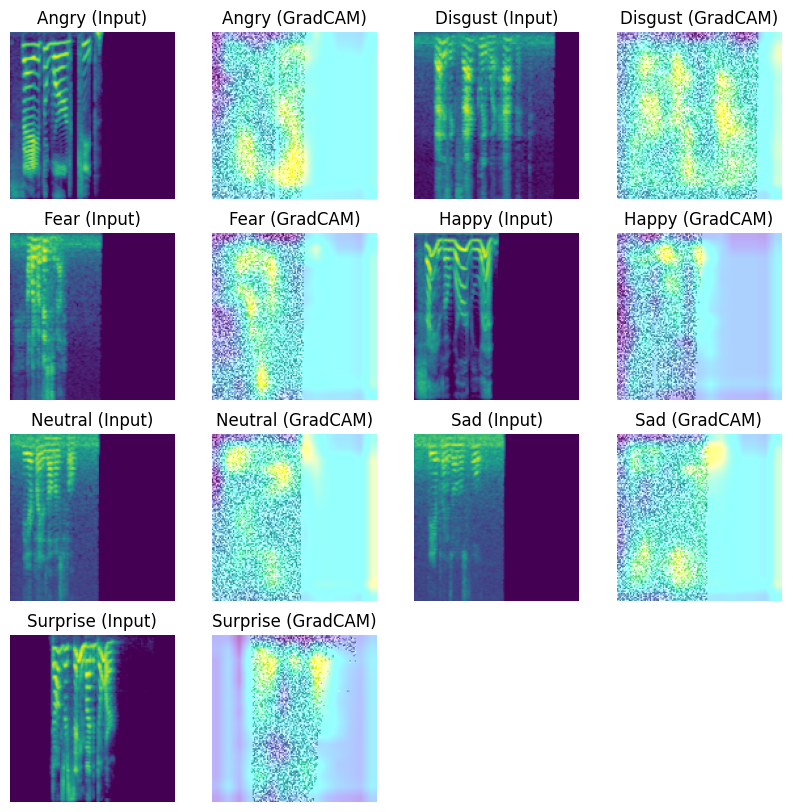

In [23]:
layer_name = "conv2d_7"

# run a forward pass once to make sure the model sees the data
_ = model1.predict(np.expand_dims(X_test[0], axis=0).astype(np.float32))

fig, ax = plt.subplots(4,4,figsize = (10,10))
ax = ax.flatten()

for i in range(7):

  # index of the subplot to plot the original image (0,2,4,...,12)
  plot_index = 2*(i+1) - 2

  # input from each emotion
  X_sample = np.expand_dims(X_test[i], axis = 0).astype(np.float32)  # add the batch dimension -> (1, 128, 126, 1)
  y_sample = np.array([i])

  pred_class = np.argmax(model1.predict(X_sample))

  # GradCAM value
  grid = explainer = GradCAM()
  grid = explainer.explain(
      validation_data = (X_sample, y_sample),
      model = model1,
      class_index = pred_class,
      layer_name = layer_name
  )

  # plot real spectrogram
  ax[plot_index].imshow(X_sample[0], cmap = "viridis")
  ax[plot_index].set_title(f"{emo_dict[i].capitalize()} (Input)")

  # plot the GradCAM
  ax[plot_index+1].imshow(grid, cmap = "viridis")
  ax[plot_index+1].set_title(f"{emo_dict[i].capitalize()} (GradCAM)")

  ax[plot_index].set_axis_off()
  ax[plot_index+1].set_axis_off()

ax[14].set_axis_off()
ax[15].set_axis_off()

# MFCC
The MFCC features is already extracted and saved during the model training phase, and we load them as numpy arrays from Google Drive, shuffle, and batch them. We also randomly selected one observation from each of the seven emotion as an example of how the model performs on MFCC data.

The patterns in MFCC features are less clear than Log Mel Spectrogram. The reason lies in the scale discrepancy between the energy feature (bottom row of each plot) and the other features. The MFCC energy features usually take value of approximately -3, while other MFCC features are around 0.01. As a result, the bottom row of each input appearing as a dark blue band, while the rest of the image is almost uniformly red due to the midrange of the color map.

In [12]:
SAVE_DIR = "/content/drive/MyDrive/SER_data/"

# Feature extraction and preprocessing
# Define paths for saved features
X_TRAIN_PATH = os.path.join(SAVE_DIR, "X_train_mfcc.npy")
Y_TRAIN_PATH = os.path.join(SAVE_DIR, "y_train_mfcc.npy")
X_VAL_PATH = os.path.join(SAVE_DIR, "X_val_mfcc.npy")
Y_VAL_PATH = os.path.join(SAVE_DIR, "y_val_mfcc.npy")

In [13]:
# Load features and prepare datasets
# Load Preprocessed Train & Val Sets
X_train = np.load(X_TRAIN_PATH)
y_train = np.load(Y_TRAIN_PATH)
X_val = np.load(X_VAL_PATH)
y_val = np.load(Y_VAL_PATH)

print("Loaded features from files:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Standardize features => Improved the acc by 1%
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Loaded features from files:
X_train shape: (9729, 41, 216, 1)
y_train shape: (9729, 7)
X_val shape: (2433, 41, 216, 1)
y_val shape: (2433, 7)


In [14]:
sample_dict = {}
labels = np.argmax(y_val, axis=1)

# For each label 0 to 6 (7 emotions)
for label in range(7):
    indices = np.where(labels == label)[0]
    if len(indices) == 0:
        print(f"No samples for label {label}")
        continue
    rng = np.random.default_rng(seed=42)  # fixed seed for reproducibility
    idx = rng.choice(indices)
    sample_dict[label] = X_val[idx]  # tuple of (features, label)

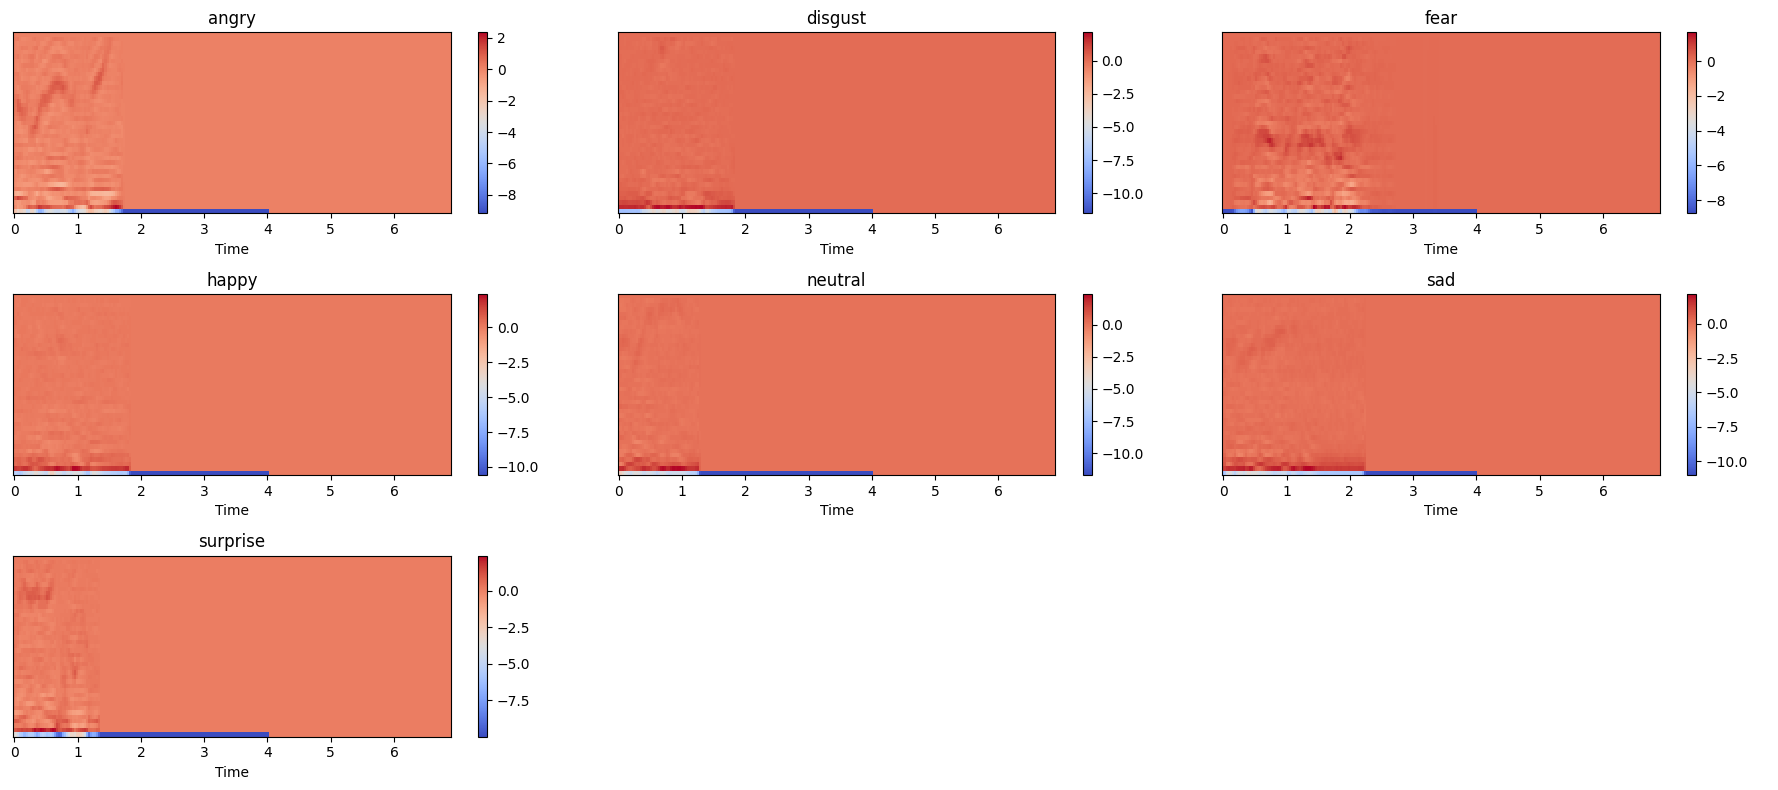

In [84]:
X_test = []
# plot Log Mel-Spectrogram
fig, ax = plt.subplots(3,3, figsize = (18,8))

for i in range(7):

  ax = ax.flatten()
  img = librosa.display.specshow(np.squeeze(sample_dict[i]), x_axis='time', sr=16000, ax = ax[i])
  ax[i].set(title = f"{emo_dict[i]}")
  fig.colorbar(img, ax = ax[i])
  plt.tight_layout()

ax[7].set_axis_off()
ax[8].set_axis_off()

plt.show()

## Model Training

In [15]:
input_shape = (41,216,1)

# Deep CNN Model Definition and Training
print("\nDeep CNN Model")

def build_deep_cnn(input_shape=(41, 216, 1), num_classes=7):
  input_shape = tf.keras.Input(shape=input_shape)

  for filters, dropout in zip([32, 64, 128, 256], [0, 0, 0.1, 0.2]):
    if filters == 32: # different input for the first block
      x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(input_shape)
    else:
      x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

  return tf.keras.Model(input_shape, x)

model2 = build_deep_cnn(input_shape=X_train.shape[1:], num_classes=y_train.shape[1])
model2.summary()

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_acc')]
)

callbacks2 = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(os.path.join(SAVE_DIR, "best_deep_cnn_model.keras"),
                  save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
]

history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks2
)


Deep CNN Model


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 41, 216, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 41, 216, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 41, 216, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 41, 216, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 20, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 27, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 27, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 5, 27, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 13, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 13, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6656)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,704,19

 Total params: 2,095,751 (7.99 MB)

 Trainable params: 2,094,791 (7.99 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1967 - loss: 3.2143 - top_3_acc: 0.5294
Epoch 1: val_accuracy improved from -inf to 0.19605, saving model to /content/drive/MyDrive/SER_data/best_deep_cnn_model.keras
305/305 ━━━━━━━━━━━━━━━━━━━━ 27s 51ms/step - accuracy: 0.1968 - loss: 3.2114 - top_3_acc: 0.5296 - val_accuracy: 0.1961 - val_loss: 2.0622 - val_top_3_acc: 0.5171 - learning_rate: 0.0010
Epoch 2/50
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2831 - loss: 1.8815 - top_3_acc: 0.6890
Epoch 2: val_accuracy improved from 0.19605 to 0.34690, saving model to /content/drive/MyDrive/SER_data/best_deep_cnn_model.keras
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2833 - loss: 1.8810 - top_3_acc: 0.6891 - val_accuracy: 0.3469 - val_loss: 1.6683 - val_top_3_acc: 0.7435 - learning_rate: 0.0010
Epoch 3/50
301/305 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3178 - loss: 1.7114 - top_3_acc: 0.7251
Epoch 3: val_accuracy improved from 0.34690 to 0.

## GradCAM
Similar to Log Mel SPectrogram, we selected the last convolutional layer (conv2d_3) for Grad-CAM. We started by running a prediction on the first sample (angry), as running the model once is required for the algorithm. We then apply Grad-CAM algorithm on each of the sampled data from each emotion label, and create a plot to compare the input image and the Grad-CAM output side-by-side.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 41, 216, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


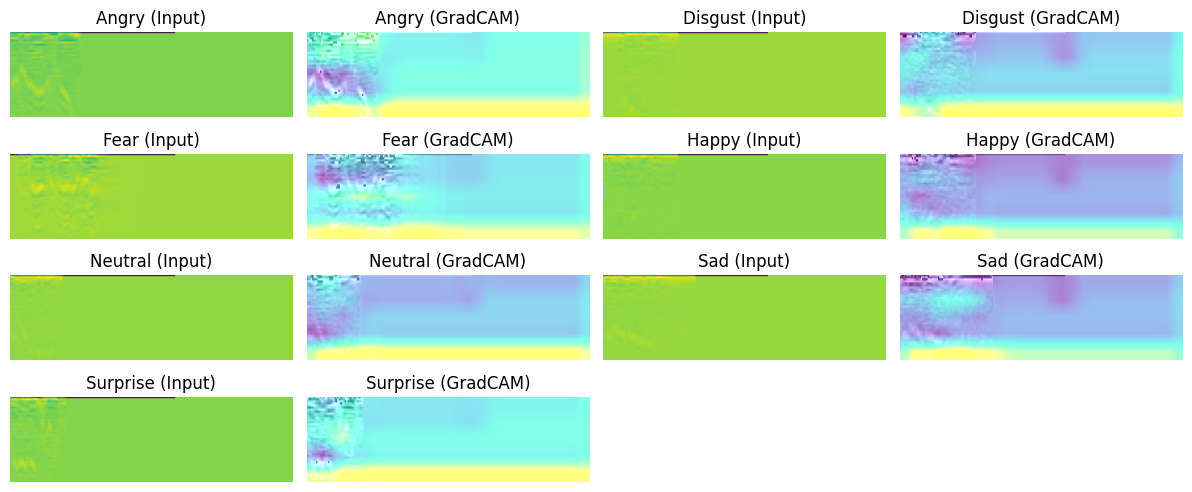

In [28]:
layer_name = "conv2d_3"

# run a forward pass once to make sure the model sees the data
_ = model2.predict(np.expand_dims(sample_dict[0], axis=0).astype(np.float32))

fig, ax = plt.subplots(4,4,figsize = (12,5))
ax = ax.flatten()

for i in range(7):

  # index of the subplot to plot the original image (0,2,4,...,12)
  plot_index = 2*(i+1) - 2

  # input from each emotion
  X_sample = np.expand_dims(sample_dict[i], axis = 0).astype(np.float32)  # add the batch dimension -> (1, 128, 126, 1)
  y_sample = np.array([i])

  pred_class = np.argmax(model2.predict(X_sample))
  # GradCAM value
  grid = explainer = GradCAM()
  grid = explainer.explain(
      validation_data = (X_sample, y_sample),
      model = model2,
      class_index = pred_class,
      layer_name = layer_name
  )

  # plot real spectrogram
  ax[plot_index].imshow(np.squeeze(sample_dict[i]), cmap = "viridis")
  ax[plot_index].set_title(f"{emo_dict[i].capitalize()} (Input)")

  # plot the GradCAM
  ax[plot_index+1].imshow(grid, cmap = "viridis")
  ax[plot_index+1].set_title(f"{emo_dict[i].capitalize()} (GradCAM)")

  ax[plot_index].set_axis_off()
  ax[plot_index+1].set_axis_off()

ax[14].set_axis_off()
ax[15].set_axis_off()

# Reduce vertical and horizontal spacing
fig.subplots_adjust(wspace=0.2, hspace=0.3)

# Force square aspect ratio (optional, helps unify layout)
for a in ax:
    a.set_aspect('auto')

fig.tight_layout(pad=1.0)

# Findings
- In both representations, we observe that the raw inputs are zero-padded on the right side to fit the 4-second duration constraint. This is reflected in the Grad-CAM heatmaps, where attention is mostly concentrated on the left side, which is the region containing actual signal.

- For high-arousal emotions such as Angry and Fear, strong energy patterns are apparent in both MFCC and Log-Mel Spectrogram features. The corresponding Grad-CAM activations highlight these regions with brighter colors
, suggesting that the model learns to associate such spectral dynamics with these emotional classes.

- In contrast, Grad-CAM results for subtler emotions (e.g. Happy, Neutral), are less concentrated.

- Both models are capable of focusing on meaningful regions in the input.

- While Log-Mel Spectrogram provides more interpretable inputs and produces more localized Grad-CAM responses, it has a lower validation accuracy than MFCC, possibly due to the irrelevant noises it also captures